In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "serif"

In [2]:
import tensorflow as tf
from keras.layers import Dense, Input, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="1"

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=24220)]) #in MB

In [6]:
def reweight(events,model,batch_size=10000):
    f = model.predict(events, batch_size=batch_size)
    f = np.clip(f,0.0001,1-0.0001)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

In [7]:
def reset_weights(model):
    for layer in model.layers:         
        if hasattr(layer, 'kernel_initializer') and \
                hasattr(layer, 'bias_initializer'):
            layer.set_weights([layer.kernel_initializer(shape=np.asarray(layer.kernel.shape)), \
                layer.bias_initializer(shape=np.asarray(layer.bias.shape))])

In [41]:
earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

def marginal_reweight(myT0, myT2, model):
    #reweight T0 to T2.
    #returns the weights applied to myT0.
    #if myT0\in\mathbb{R}^n and myR0\in\mathbb{R}^m, then model takes as an n-dimensional input.

    #Next, marginal reweighting
    reset_weights(model)

    xvals_1 = np.concatenate([myT2,myT0])
    yvals_1 = np.concatenate([np.ones(len(myT2)),np.zeros(len(myT0))])
    X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

    reset_weights(model)
    model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=50,
              batch_size=1000,
              validation_data=(X_test_1, Y_test_1),verbose=True,callbacks=[earlystopping])

    wT0 = reweight(myT0,model)
    return wT0

def conditional_reweight_2funcs(myT0, myT1, myT2, myR0, myR1, myR2, model, model2):
    #reweight R1|T1 to R0|T0.
    #returns the weights applied to (R2,T2).
    #if myT0\in\mathbb{R}^n and myR0\in\mathbb{R}^m, then model takes as an n-dimensional input and model2 takes an n+m-dimensional input.
    
    xvals_1 = np.concatenate([myT1,myT0])
    yvals_1 = np.concatenate([np.zeros(len(myT1)),np.ones(len(myT0))])
    X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

    reset_weights(model)
    model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=50,
              batch_size=1000,
              validation_data=(X_test_1, Y_test_1),verbose=True,callbacks=[earlystopping])

    reset_weights(model2)

    xvals_1 = np.concatenate([np.c_[myT1,myR1],np.c_[myT0,myR0]])
    yvals_1 = np.concatenate([np.zeros(len(myT1)),np.ones(len(myT0))])
    X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

    model2.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
    h = model2.fit(X_train_1,
              Y_train_1,
              epochs=50,
              batch_size=1000,
              validation_data=(X_test_1, Y_test_1),verbose=True,callbacks=[earlystopping])

    wT = reweight(myT2,model)
    wRT = reweight(np.c_[myT2,myR2],model2)
    return wRT/wT

def conditional_reweight_1func(myT0, myT1, myT2, myR0, myR1, myR2, model):
    #reweight R1|T1 to R0|T0.
    #returns the weights applied to (R2,T2).
    #if myT0\in\mathbb{R}^n and myR0\in\mathbb{R}^m, then model takes as input a 2n+m-dimensional input.

    #Make the 4d data for the special training
    x = []
    y = []
    for k in range(1):
        inds = np.random.randint(0,len(myT1),len(myT0))
        #x = np.concatenate([x,np.c_[myR0,myT0,myT1[inds]]])
        #x = np.concatenate([x,np.c_[myR1,myT0,myT1[inds]]])
        #y = np.concatenate([y,np.ones(len(myR0))])
        #y = np.concatenate([y,np.ones(len(myR0))])
        for i in range(len(myT0)):
            #if i%10000==0:
            #    print("on i=",i)
            x+=[[myR0[i],myT0[i],myT1[inds[i]]]]
            x+=[[myR1[inds[i]],myT0[i],myT1[inds[i]]]]
            y+=[1]
            y+=[0]
       
    xprime = np.c_[myR2,myT2,myT2]
    #for i in range(len(myT2)):
    #    xprime+=[[myR2[i],myT2[i],myT2[i]]]
        
    X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(x, y)
    
    reset_weights(model)
    model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=50,
              batch_size=1000,
              validation_data=(X_test_1, Y_test_1),verbose=True,callbacks=[earlystopping])
    
    wT0 = reweight(xprime,model)
    return wT0

In [9]:
def makeplots(myTt,myT0,myT1,myT2,mywT0,mywRT,mywRT2,xlabel=r"$T$",header="Gaussian Example",plotname="Gaussian_T",mymin=-12,mymax=4,w_withall=np.ones(1),nbins=50):

    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 

    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=20)
    ax0.minorticks_on()

    if ("Dijets" not in plotname):
        nTt,_,_=plt.hist(myTt,bins=np.linspace(mymin,mymax,nbins),label="Target",histtype="step",color="black",lw=5,alpha=0.3,density=True)
    else:
        nTt,_,_=plt.hist(myTt,bins=np.linspace(mymin,mymax,nbins),weights=w_withall,label="Target",histtype="step",color="black",lw=5,alpha=0.3,density=True)
    nT0,bTt,_=plt.hist(myT0,bins=np.linspace(mymin,mymax,nbins),alpha=0.5,label="(I)",density=True)
    nT0wT0,_,_=plt.hist(myT0,weights=mywT0,bins=np.linspace(mymin,mymax,nbins),label="(I) + Marginal",histtype="step",lw=2,color="blue",ls="--",density=True)
    nT1,_,_=plt.hist(myT1,bins=np.linspace(mymin,mymax,nbins),histtype="step",color="black",label="(II)",density=True)
    nT2,_,_=plt.hist(myT2,bins=np.linspace(mymin,mymax,nbins),alpha=0.5,label="(III)",density=True)
    nT2wRT,_,_=plt.hist(myT2,weights=mywRT,bins=np.linspace(mymin,mymax,nbins),label="(III) + Cond. (2f)",histtype="step",color="red",lw=2,ls=":",density=True)
    nT2wRT2,_,_=plt.hist(myT2,weights=mywRT2,bins=np.linspace(mymin,mymax,nbins),label="(III) + Cond. (1f)",histtype="step",color="red",lw=2,ls="--",density=True)
    plt.ylabel("Normalized to Unity")
    plt.xlim([mymin,mymax])
    plt.locator_params(axis='y', nbins=6)
    plt.legend(frameon=False,fontsize=20)
    _=plt.title(header,loc="right",fontsize=20, fontstyle="italic")
    
    ax1 = plt.subplot(gs[1])
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(direction="in",which="both")
    ax1.minorticks_on()
    plt.xlim([mymin,mymax])
    plt.locator_params(axis='x', nbins=6)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel("1/target",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    plt.axhline(y=1,linewidth=2, color='gray')   
    plt.plot(0.5*(bTt[1:]+bTt[:-1]),nT0/(0.000001+nTt),color='tab:blue')
    plt.plot(0.5*(bTt[1:]+bTt[:-1]),nT0wT0/(0.000001+nTt),color='blue',ls="--")
    plt.plot(0.5*(bTt[1:]+bTt[:-1]),nT1/(0.000001+nTt),color='black')
    plt.plot(0.5*(bTt[1:]+bTt[:-1]),nT2/(0.000001+nTt),color='tab:orange')
    plt.plot(0.5*(bTt[1:]+bTt[:-1]),nT2wRT/(0.000001+nTt),color='red',ls=":")
    plt.plot(0.5*(bTt[1:]+bTt[:-1]),nT2wRT2/(0.000001+nTt),color='red',ls="--")
    plt.ylim(0.5,1.5)

    plt.savefig("conditional/"+plotname+".pdf",bbox_inches='tight')

## Gaussian case

First, no gap in phase space.

$T \sim N(\mu,\sigma)$

(I): $\mu = \mu_0, \sigma = \sigma_0$

(II): $\mu = \mu_0, \sigma = \sigma_0$

(III): $\mu = \mu_1, \sigma = \sigma_1$

$R \sim N(T+b,\epsilon)$

(I): $b = b_0, \epsilon = \epsilon_0$

(II): $b = b_1, \epsilon = \epsilon_1$

(III): $b = b_1, \epsilon = \epsilon_1$

In [10]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

inputs2 = Input((2, ))
hidden_layer_12 = Dense(50, activation='relu')(inputs2)
hidden_layer_22 = Dense(50, activation='relu')(hidden_layer_12)
hidden_layer_32 = Dense(50, activation='relu')(hidden_layer_22)
outputs2 = Dense(1, activation='sigmoid')(hidden_layer_32)
model2 = Model(inputs=inputs2, outputs=outputs2)

inputsO = Input((3, ))
hidden_layer_1O = Dense(50, activation='relu')(inputsO)
hidden_layer_2O = Dense(50, activation='relu')(hidden_layer_1O)
hidden_layer_3O = Dense(50, activation='relu')(hidden_layer_2O)
outputsO = Dense(1, activation='sigmoid')(hidden_layer_3O)
modelO = Model(inputs=inputsO, outputs=outputsO)

In [11]:
n = 100000

mu0 = 0.
mu1 = 0.1
sigma0 = 1
sigma1 = 1.5

b0 = 0.
b1 = 0.5
eps0 = 0.5
eps1 = 0.3

T0 = np.random.normal(mu0,sigma0,n)
T1 = np.random.normal(mu0,sigma0,n)

T2 = np.random.normal(mu1,sigma1,n)
Tt = np.random.normal(mu1,sigma1,n)

R0 = np.random.normal(T0+b0,eps0)
R1 = np.random.normal(T1+b1,eps1)
R2 = np.random.normal(T2+b1,eps1)
Rt = np.random.normal(Tt+b0,eps0)

In [12]:
wCondtional_2funcs = conditional_reweight_2funcs(T0, T1, T2, R0, R1, R2, model, model2)
wCondtional_1func = conditional_reweight_1func(T0, T1, T2, R0, R1, R2, modelO)
wMarginal = marginal_reweight(T0, T2, model)

Epoch 1/50
15/15 [==============================] - 0s 10ms/step - loss: 0.6936 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4989
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4974
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4996
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 7/50
15/15 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 8/50
15/15 [=

15/15 [==============================] - 0s 4ms/step - loss: 0.5062 - accuracy: 0.7490 - val_loss: 0.5077 - val_accuracy: 0.7473
Epoch 34/50
15/15 [==============================] - 0s 4ms/step - loss: 0.5060 - accuracy: 0.7491 - val_loss: 0.5075 - val_accuracy: 0.7471
Epoch 35/50
15/15 [==============================] - 0s 4ms/step - loss: 0.5058 - accuracy: 0.7490 - val_loss: 0.5075 - val_accuracy: 0.7479
Epoch 36/50
15/15 [==============================] - 0s 5ms/step - loss: 0.5058 - accuracy: 0.7488 - val_loss: 0.5074 - val_accuracy: 0.7471
Epoch 37/50
15/15 [==============================] - 0s 4ms/step - loss: 0.5057 - accuracy: 0.7489 - val_loss: 0.5073 - val_accuracy: 0.7469
Epoch 38/50
15/15 [==============================] - 0s 4ms/step - loss: 0.5057 - accuracy: 0.7488 - val_loss: 0.5073 - val_accuracy: 0.7468
Epoch 39/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5055 - accuracy: 0.7490 - val_loss: 0.5071 - val_accuracy: 0.7473
Epoch 40/50
15/15 [======

Epoch 41/50
15/15 [==============================] - 1s 40ms/step - loss: 0.2801 - accuracy: 0.8604 - val_loss: 0.2825 - val_accuracy: 0.8579
Epoch 42/50
15/15 [==============================] - 1s 38ms/step - loss: 0.2799 - accuracy: 0.8605 - val_loss: 0.2828 - val_accuracy: 0.8586
Epoch 43/50
15/15 [==============================] - 1s 37ms/step - loss: 0.2803 - accuracy: 0.8599 - val_loss: 0.2826 - val_accuracy: 0.8586
Epoch 44/50
15/15 [==============================] - 1s 37ms/step - loss: 0.2798 - accuracy: 0.8605 - val_loss: 0.2824 - val_accuracy: 0.8587
Epoch 45/50
15/15 [==============================] - 1s 43ms/step - loss: 0.2804 - accuracy: 0.8600 - val_loss: 0.2825 - val_accuracy: 0.8580
Epoch 46/50
15/15 [==============================] - 1s 38ms/step - loss: 0.2812 - accuracy: 0.8598 - val_loss: 0.2828 - val_accuracy: 0.8581
Epoch 47/50
15/15 [==============================] - 1s 38ms/step - loss: 0.2801 - accuracy: 0.8600 - val_loss: 0.2831 - val_accuracy: 0.8578
Epoch 

15/15 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.5975 - val_loss: 0.6567 - val_accuracy: 0.5946
Epoch 50/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.5975 - val_loss: 0.6567 - val_accuracy: 0.5945


In [13]:
Tt_copy = Tt.copy()
T0_copy = T0.copy()
T1_copy = T1.copy()
T2_copy = T2.copy()
wT0_copy = wMarginal.copy()

Rt_copy = Rt.copy()
R0_copy = R0.copy()
R1_copy = R1.copy()
R2_copy = R2.copy()
wRT_copy = wCondtional_2funcs.copy()
wRT2_copy = wCondtional_1func.copy()

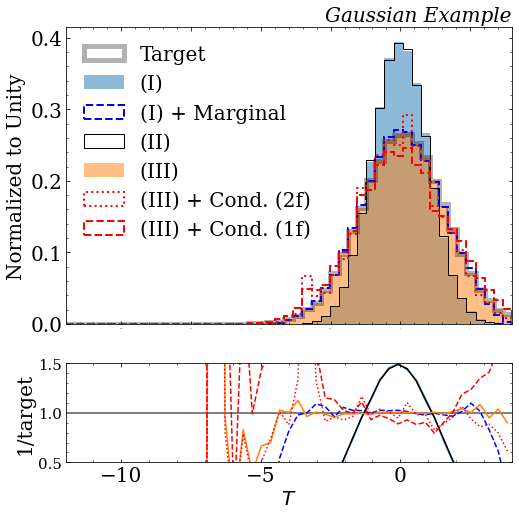

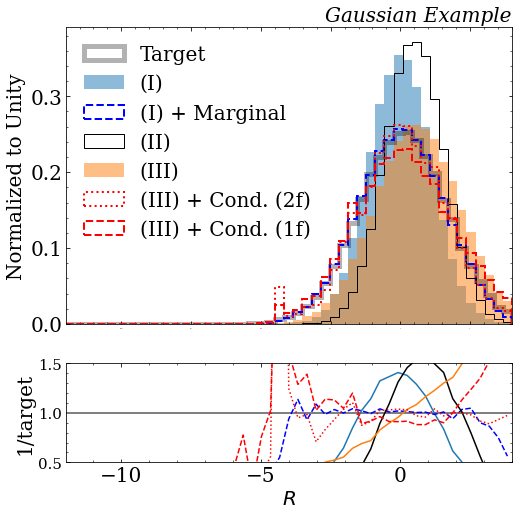

In [14]:
makeplots(Tt_copy,T0_copy,T1_copy,T2_copy,wT0_copy,wRT_copy,wRT2_copy,xlabel=r"$T$",header="Gaussian Example",plotname="Gaussian_T")
makeplots(Rt_copy,R0_copy,R1_copy,R2_copy,wT0_copy,wRT_copy,wRT2_copy,xlabel=r"$R$",header="Gaussian Example",plotname="Gaussian_R")

In [15]:
n = 100000

mu0 = 0.
mu1 = 0.3
sigma0 = 1.5
sigma1 = 1.8

b0 = 0.
b1 = 0.2
eps0 = 0.5
eps1 = 0.3

T0 = np.random.normal(mu0,sigma0,n*5)
T1 = np.random.normal(mu0,sigma0,n*5)

T1 = T1[(T1 < 1.5) + (T1 > 2)]
T1 = T1[0:n]

T0 = T0[(T0 < 1.5) + (T0 > 2)]
T0 = T0[0:n]

T2 = np.random.normal(mu1,sigma1,n)
Tt = np.random.normal(mu1,sigma1,n)

R0 = np.random.normal(T0+b0,eps0)
R1 = np.random.normal(T1+b1,eps1)
R2 = np.random.normal(T2+b1,eps1)
Rt = np.random.normal(Tt+b0,eps0)

In [16]:
wCondtional_2funcs = conditional_reweight_2funcs(T0, T1, T2, R0, R1, R2, model, model2)
wCondtional_1func = conditional_reweight_1func(T0, T1, T2, R0, R1, R2, modelO)
wMarginal = marginal_reweight(T0, T2, model)

Epoch 1/50
15/15 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 8/50
15/15 [==

Epoch 10/50
15/15 [==============================] - 1s 38ms/step - loss: 0.2215 - accuracy: 0.8917 - val_loss: 0.2212 - val_accuracy: 0.8926
Epoch 11/50
15/15 [==============================] - 1s 41ms/step - loss: 0.2209 - accuracy: 0.8917 - val_loss: 0.2204 - val_accuracy: 0.8929
Epoch 12/50
15/15 [==============================] - 1s 38ms/step - loss: 0.2203 - accuracy: 0.8921 - val_loss: 0.2199 - val_accuracy: 0.8932
Epoch 13/50
15/15 [==============================] - 1s 38ms/step - loss: 0.2199 - accuracy: 0.8922 - val_loss: 0.2198 - val_accuracy: 0.8932
Epoch 14/50
15/15 [==============================] - 1s 40ms/step - loss: 0.2196 - accuracy: 0.8920 - val_loss: 0.2193 - val_accuracy: 0.8926
Epoch 15/50
15/15 [==============================] - 1s 43ms/step - loss: 0.2192 - accuracy: 0.8923 - val_loss: 0.2189 - val_accuracy: 0.8928
Epoch 16/50
15/15 [==============================] - 1s 39ms/step - loss: 0.2189 - accuracy: 0.8922 - val_loss: 0.2189 - val_accuracy: 0.8923
Epoch 

Epoch 18/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.5800 - val_loss: 0.6724 - val_accuracy: 0.5801
Epoch 19/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5800 - val_loss: 0.6721 - val_accuracy: 0.5805
Epoch 20/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5801 - val_loss: 0.6718 - val_accuracy: 0.5801
Epoch 21/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5796 - val_loss: 0.6714 - val_accuracy: 0.5804
Epoch 22/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5803 - val_loss: 0.6709 - val_accuracy: 0.5800
Epoch 23/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.5801 - val_loss: 0.6705 - val_accuracy: 0.5802
Epoch 24/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5802 - val_loss: 0.6697 - val_accuracy: 0.5800
Epoch 25/50
1

In [17]:
Tt_copy2 = Tt.copy()
T0_copy2 = T0.copy()
T1_copy2 = T1.copy()
T2_copy2 = T2.copy()
wT0_copy2 = wMarginal.copy()

Rt_copy2 = Rt.copy()
R0_copy2 = R0.copy()
R1_copy2 = R1.copy()
R2_copy2 = R2.copy()
wRT_copy2 = wCondtional_2funcs.copy()
wRT2_copy2 = wCondtional_1func.copy()

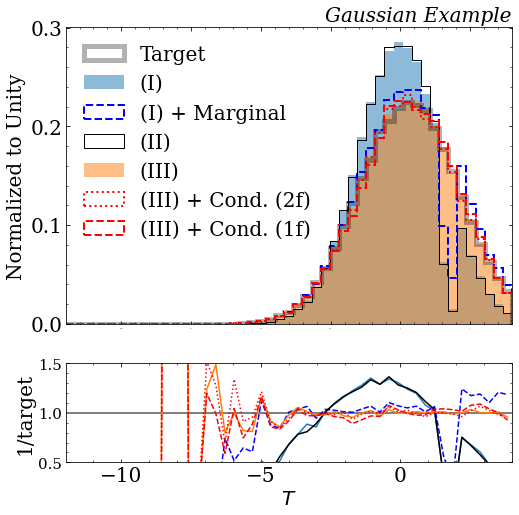

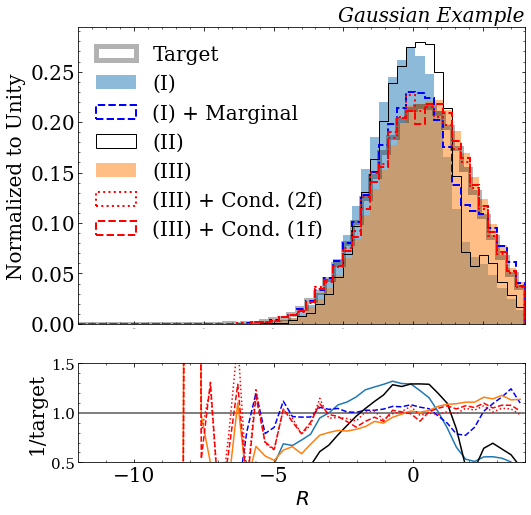

In [18]:
makeplots(Tt_copy2,T0_copy2,T1_copy2,T2_copy2,wT0_copy2,wRT_copy2,wRT2_copy2,xlabel=r"$T$",header="Gaussian Example",plotname="Gaussian_T_withhole")
makeplots(Rt_copy2,R0_copy2,R1_copy2,R2_copy2,wT0_copy2,wRT_copy2,wRT2_copy2,xlabel=r"$R$",header="Gaussian Example",plotname="Gaussian_R_withhole")

In [19]:
n = 100000

mu0 = 0
mu1 = 2 #scan this
sigma0 = 0.5
sigma1 = 0.5

b0 = 0
b1 = 0
eps0 = 0.3 #scan this
eps1 = 0.4

T0 = np.random.normal(mu0,sigma0,n)
T1 = np.random.normal(mu0,sigma0,n)

T2 = np.random.normal(mu1,sigma1,n)
Tt = np.random.normal(mu1,sigma1,n)

R0 = np.random.normal(T0+b0,eps0)
R1 = np.random.normal(T1+b1,eps1)
R2 = np.random.normal(T2+b1,eps1)
Rt = np.random.normal(Tt+b0,eps0)

In [20]:
wCondtional_2funcs = conditional_reweight_2funcs(T0, T1, T2, R0, R1, R2, model, model2)
wCondtional_1func = conditional_reweight_1func(T0, T1, T2, R0, R1, R2, modelO)
wMarginal = marginal_reweight(T0, T2, model)

Epoch 1/50
15/15 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5044
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4967
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4971
Epoch 8/50
15/15 [=

Epoch 7/50
15/15 [==============================] - 1s 43ms/step - loss: 0.4535 - accuracy: 0.7597 - val_loss: 0.4535 - val_accuracy: 0.7584
Epoch 8/50
15/15 [==============================] - 1s 44ms/step - loss: 0.4522 - accuracy: 0.7602 - val_loss: 0.4527 - val_accuracy: 0.7585
Epoch 9/50
15/15 [==============================] - 1s 43ms/step - loss: 0.4513 - accuracy: 0.7598 - val_loss: 0.4521 - val_accuracy: 0.7571
Epoch 10/50
15/15 [==============================] - 1s 40ms/step - loss: 0.4507 - accuracy: 0.7601 - val_loss: 0.4516 - val_accuracy: 0.7561
Epoch 11/50
15/15 [==============================] - 1s 38ms/step - loss: 0.4498 - accuracy: 0.7604 - val_loss: 0.4505 - val_accuracy: 0.7582
Epoch 12/50
15/15 [==============================] - 1s 41ms/step - loss: 0.4493 - accuracy: 0.7601 - val_loss: 0.4499 - val_accuracy: 0.7585
Epoch 13/50
15/15 [==============================] - 1s 38ms/step - loss: 0.4490 - accuracy: 0.7602 - val_loss: 0.4494 - val_accuracy: 0.7605
Epoch 14/

Epoch 15/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.9767 - val_loss: 0.0605 - val_accuracy: 0.9770
Epoch 16/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0615 - accuracy: 0.9767 - val_loss: 0.0606 - val_accuracy: 0.9769
Epoch 17/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0615 - accuracy: 0.9768 - val_loss: 0.0606 - val_accuracy: 0.9771
Epoch 18/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0615 - accuracy: 0.9766 - val_loss: 0.0605 - val_accuracy: 0.9769
Epoch 19/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.9766 - val_loss: 0.0604 - val_accuracy: 0.9769
Epoch 20/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0614 - accuracy: 0.9767 - val_loss: 0.0604 - val_accuracy: 0.9771
Epoch 21/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0615 - accuracy: 0.9766 - val_loss: 0.0605 - val_accuracy: 0.9771
Epoch 22/50
1

In [21]:
Tt_copy3 = Tt.copy()
T0_copy3 = T0.copy()
T1_copy3 = T1.copy()
T2_copy3 = T2.copy()
wT0_copy3 = wMarginal.copy()

Rt_copy3 = Rt.copy()
R0_copy3 = R0.copy()
R1_copy3 = R1.copy()
R2_copy3 = R2.copy()
wRT_copy3 = wCondtional_2funcs.copy()
wRT2_copy3 = wCondtional_1func.copy()

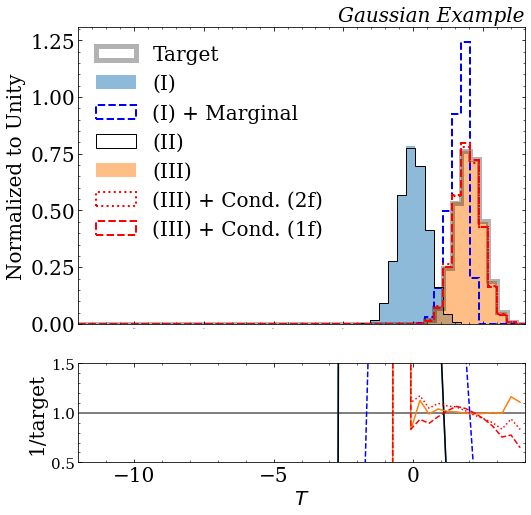

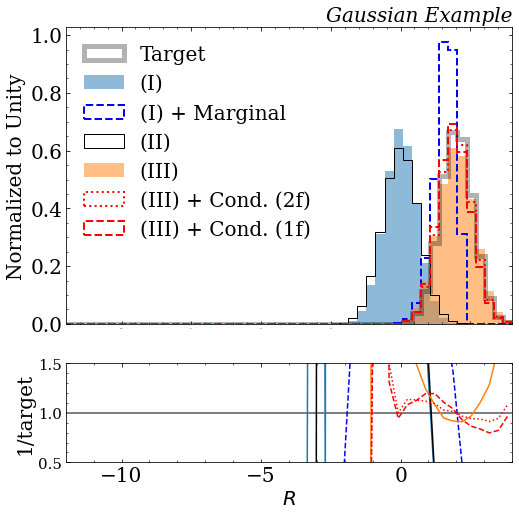

In [22]:
makeplots(Tt_copy3,T0_copy3,T1_copy3,T2_copy3,wT0_copy3,wRT_copy3,wRT2_copy3,xlabel=r"$T$",header="Gaussian Example",plotname="Gaussian_T_onedge")
makeplots(Rt_copy3,R0_copy3,R1_copy3,R2_copy3,wT0_copy3,wRT_copy3,wRT2_copy3,xlabel=r"$R$",header="Gaussian Example",plotname="Gaussian_R_onedge")

## Now try a physics example

In [23]:
import energyflow as ef

/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/energyflow/emd.py:915: UserWarning: emd module requires 'wasserstein' or 'pot', both of which are unavailable
  warnings.warn(message)


In [24]:
sim = ef.mod.load(dataset='sim',subdatasets=["SIM1000_Jet300_pT375-infGeV"])

In [25]:
gen = ef.mod.load(dataset='gen',subdatasets=["GEN1000_pT375-infGeV"])

In [26]:
sim14 = ef.mod.load(dataset='sim',subdatasets=["SIM1400_Jet300_pT375-infGeV"])
sim18 = ef.mod.load(dataset='sim',subdatasets=["SIM1800_Jet300_pT375-infGeV"])

In [27]:
gen14 = ef.mod.load(dataset='gen',subdatasets=["GEN1400_pT375-infGeV"])
gen18 = ef.mod.load(dataset='gen',subdatasets=["GEN1800_pT375-infGeV"])

In [28]:
simjets_f = sim.jets_f[0:20000]
sim14jets_f = sim14.jets_f[0:20000]
sim18jets_f = sim18.jets_f[0:20000]

In [29]:
myfile = open("output.text")
delphes = []
for line in myfile:
    delphes+=[[float(line.split()[0]),float(line.split()[1]),
               float(line.split()[2]),float(line.split()[3]),
               float(line.split()[4]),float(line.split()[5]),
               float(line.split()[6]),float(line.split()[7]),
               float(line.split()[8]),float(line.split()[9])]]
delphes = np.array(delphes)

myfile = open("output14.text")
delphes14 = []
for line in myfile:
    delphes14+=[[float(line.split()[0]),float(line.split()[1]),
               float(line.split()[2]),float(line.split()[3]),
               float(line.split()[4]),float(line.split()[5]),
               float(line.split()[6]),float(line.split()[7]),
               float(line.split()[8]),float(line.split()[9])]]
delphes14 = np.array(delphes14)

myfile = open("output18.text")
delphes18 = []
for line in myfile:
    delphes18+=[[float(line.split()[0]),float(line.split()[1]),
               float(line.split()[2]),float(line.split()[3]),
               float(line.split()[4]),float(line.split()[5]),
               float(line.split()[6]),float(line.split()[7]),
               float(line.split()[8]),float(line.split()[9])]]
delphes18 = np.array(delphes18)

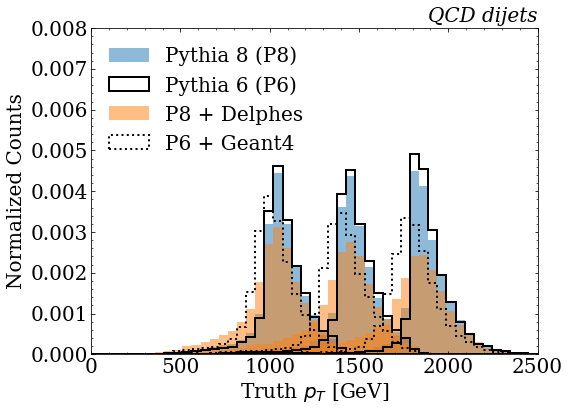

In [30]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(delphes[:,6],density=True,alpha=0.5,bins=np.linspace(0,2500,50),label="Pythia 8 (P8)")
_,_,_=plt.hist(delphes14[:,6],density=True,alpha=0.5,bins=np.linspace(0,2500,50),color="tab:blue")
_,_,_=plt.hist(delphes18[:,6],density=True,alpha=0.5,bins=np.linspace(0,2500,50),color="tab:blue")
_,_,_=plt.hist(simjets_f[:,8],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",lw=2,label="Pythia 6 (P6)")
_,_,_=plt.hist(sim14jets_f[:,8],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",lw=2)
_,_,_=plt.hist(sim18jets_f[:,8],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",lw=2)

_,_,_=plt.hist(delphes[:,1],density=True,alpha=0.5,bins=np.linspace(0,2500,50),label="P8 + Delphes")
_,_,_=plt.hist(delphes14[:,1],density=True,alpha=0.5,bins=np.linspace(0,2500,50),color="tab:orange")
_,_,_=plt.hist(delphes18[:,1],density=True,alpha=0.5,bins=np.linspace(0,2500,50),color="tab:orange")
_,_,_=plt.hist(simjets_f[:,0],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",ls=":",lw=2,label="P6 + Geant4")
_,_,_=plt.hist(sim14jets_f[:,0],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",ls=":",lw=2)
_,_,_=plt.hist(sim18jets_f[:,0],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",ls=":",lw=2)

plt.ylim([0,0.008])
#plt.yscale("log")
plt.xlim([0,2500])
plt.xlabel("Truth $p_T$ [GeV]")
plt.ylabel("Normalized Counts")
plt.legend(frameon=False,fontsize=20,loc="upper left")
_=plt.title(r"QCD dijets",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Dijets_pT_more.pdf",bbox_inches='tight')

<ipython-input-31-5f93906c2c09>:18: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(Delphes_R_tot/Delphes_T_tot,alpha=0.5,bins=np.linspace(0,1.5,50),density=True,label="P8 + Delphes",color="tab:orange")


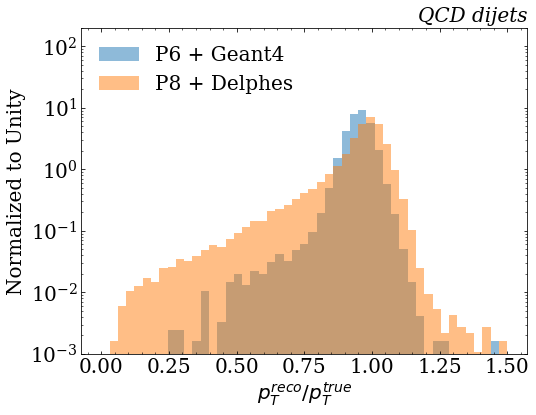

In [31]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

G4_T_tot = np.concatenate([simjets_f[:,8],sim18jets_f[:,8]])
Delphes_T_tot = np.concatenate([delphes[:,6],delphes14[:,6],delphes18[:,6]])

G4_R_tot = np.concatenate([simjets_f[:,0],sim18jets_f[:,0]])
Delphes_R_tot = np.concatenate([delphes[:,1],delphes14[:,1],delphes18[:,1]])

plt.hist(G4_R_tot/G4_T_tot,bins=np.linspace(0,1.5,50),density=True,label="P6 + Geant4",color="tab:blue",alpha=0.5)
plt.hist(Delphes_R_tot/Delphes_T_tot,alpha=0.5,bins=np.linspace(0,1.5,50),density=True,label="P8 + Delphes",color="tab:orange")
plt.xlabel("$p_T^{reco}/p_T^{true}$")
plt.ylabel("Normalized to Unity")
plt.yscale("log")
plt.legend(frameon=False,loc="upper left")
plt.ylim([1e-3,200])
_=plt.title(r"QCD dijets",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Dijets_response_pT.pdf",bbox_inches='tight')

In [32]:
inputsP = Input((1, ))
hiddenP_layer_1 = Dense(50, activation='relu')(inputsP)
hiddenP_layer_2 = Dense(50, activation='relu')(hiddenP_layer_1)
hiddenP_layer_3 = Dense(50, activation='relu')(hiddenP_layer_2)
outputsP = Dense(1, activation='sigmoid')(hiddenP_layer_3)
modelP = Model(inputs=inputsP, outputs=outputsP)

inputsP2 = Input((2, ))
hiddenP_layer_12 = Dense(50, activation='relu')(inputsP2)
hiddenP_layer_22 = Dense(50, activation='relu')(hiddenP_layer_12)
hiddenP_layer_32 = Dense(50, activation='relu')(hiddenP_layer_22)
outputsP2 = Dense(1, activation='sigmoid')(hiddenP_layer_32)
modelP2 = Model(inputs=inputsP2, outputs=outputsP2)

inputsM = Input((1, ))
hiddenM_layer_1 = Dense(50, activation='relu')(inputsM)
hiddenM_layer_2 = Dense(50, activation='relu')(hiddenM_layer_1)
hiddenM_layer_3 = Dense(50, activation='relu')(hiddenM_layer_2)
outputsM = Dense(1, activation='sigmoid')(hiddenM_layer_3)
modelM = Model(inputs=inputsM, outputs=outputsM)

In [33]:
nn = 10000

T_withall = np.concatenate([simjets_f[:,8],sim14jets_f[:,8],sim18jets_f[:,8]])
R_withall = np.concatenate([simjets_f[:,0],sim14jets_f[:,0],sim18jets_f[:,0]])
T0 = np.concatenate([simjets_f[0:nn][:,8],sim18jets_f[0:nn][:,8]])
T1 = np.concatenate([delphes[0:nn][:,6],delphes18[0:nn][:,6]])
T2 = np.concatenate([delphes[0:nn][:,6],delphes14[0:nn][:,6],delphes18[0:nn][:,6]])
T2_all = np.concatenate([delphes[:,6],delphes14[:,6],delphes18[:,6]])
R0 = np.concatenate([simjets_f[0:nn][:,0],sim18jets_f[0:nn][:,0]])
R1 = np.concatenate([delphes[0:nn][:,1],delphes18[0:nn][:,1]])
R2 = np.concatenate([delphes[0:nn][:,1],delphes14[0:nn][:,1],delphes18[0:nn][:,1]])

In [45]:
w_withall = marginal_reweight(T_withall/1000., T2/1000., model)

Epoch 1/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6573 - val_loss: 0.6375 - val_accuracy: 0.6668
Epoch 2/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6666 - val_loss: 0.6372 - val_accuracy: 0.6668
Epoch 3/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6666 - val_loss: 0.6370 - val_accuracy: 0.6670
Epoch 4/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6670 - val_loss: 0.6368 - val_accuracy: 0.6671
Epoch 5/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6671 - val_loss: 0.6370 - val_accuracy: 0.6671
Epoch 6/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6672 - val_loss: 0.6365 - val_accuracy: 0.6671
Epoch 7/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6671 - val_loss: 0.6363 - val_accuracy: 0.6674
Epoch 8/50
68/68 [==

In [46]:
wCondtional_2funcs = conditional_reweight_2funcs(T0/1000., T1/1000., T2/1000., R0/1000., R1/1000., R2/1000., model, model2)
wCondtional_1func = conditional_reweight_1func(T0/1000., T1/1000., T2/1000., R0/1000., R1/1000., R2/1000., modelO)
wMarginal = marginal_reweight(T0/1000., T2/1000., model)

Epoch 1/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5039 - val_loss: 0.6935 - val_accuracy: 0.4992
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6934 - val_accuracy: 0.5020
Epoch 3/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.5049
Epoch 4/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6932 - val_accuracy: 0.5056
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6929 - val_accuracy: 0.5024
Epoch 6/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5075 - val_loss: 0.6935 - val_accuracy: 0.5021
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4986 - val_loss: 0.6930 - val_accuracy: 0.5016
Epoch 8/50
30/30 [==

30/30 [==============================] - 0s 2ms/step - loss: 0.6225 - accuracy: 0.6703 - val_loss: 0.6162 - val_accuracy: 0.6732
Epoch 10/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6207 - accuracy: 0.6707 - val_loss: 0.6165 - val_accuracy: 0.6700
Epoch 11/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6202 - accuracy: 0.6707 - val_loss: 0.6142 - val_accuracy: 0.6702
Epoch 12/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy: 0.6694 - val_loss: 0.6109 - val_accuracy: 0.6756
Epoch 13/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6184 - accuracy: 0.6735 - val_loss: 0.6147 - val_accuracy: 0.6703
Epoch 14/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6190 - accuracy: 0.6700 - val_loss: 0.6118 - val_accuracy: 0.6724
Epoch 15/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6228 - accuracy: 0.6645 - val_loss: 0.6117 - val_accuracy: 0.6743
Epoch 16/50
30/30 [======

30/30 [==============================] - 0s 6ms/step - loss: 0.2498 - accuracy: 0.8827 - val_loss: 0.2524 - val_accuracy: 0.8823
Epoch 24/50
30/30 [==============================] - 0s 5ms/step - loss: 0.2491 - accuracy: 0.8838 - val_loss: 0.2522 - val_accuracy: 0.8812
Epoch 25/50
30/30 [==============================] - 0s 5ms/step - loss: 0.2487 - accuracy: 0.8824 - val_loss: 0.2518 - val_accuracy: 0.8824
Epoch 26/50
30/30 [==============================] - 0s 5ms/step - loss: 0.2489 - accuracy: 0.8833 - val_loss: 0.2545 - val_accuracy: 0.8750
Epoch 27/50
30/30 [==============================] - 0s 6ms/step - loss: 0.2501 - accuracy: 0.8832 - val_loss: 0.2517 - val_accuracy: 0.8801
Epoch 28/50
30/30 [==============================] - 0s 5ms/step - loss: 0.2470 - accuracy: 0.8842 - val_loss: 0.2533 - val_accuracy: 0.8793
Epoch 29/50
30/30 [==============================] - 0s 8ms/step - loss: 0.2472 - accuracy: 0.8833 - val_loss: 0.2523 - val_accuracy: 0.8807
Epoch 30/50
30/30 [======

38/38 [==============================] - 0s 4ms/step - loss: 0.5940 - accuracy: 0.6040 - val_loss: 0.5915 - val_accuracy: 0.6006
Epoch 32/50
38/38 [==============================] - 0s 3ms/step - loss: 0.5937 - accuracy: 0.6007 - val_loss: 0.5916 - val_accuracy: 0.5987
Epoch 33/50
38/38 [==============================] - 0s 3ms/step - loss: 0.5939 - accuracy: 0.6010 - val_loss: 0.5921 - val_accuracy: 0.5986
Epoch 34/50
38/38 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.6058 - val_loss: 0.5918 - val_accuracy: 0.6042
Epoch 35/50
38/38 [==============================] - 0s 3ms/step - loss: 0.5934 - accuracy: 0.6038 - val_loss: 0.5923 - val_accuracy: 0.6037
Epoch 36/50
38/38 [==============================] - 0s 3ms/step - loss: 0.5934 - accuracy: 0.6011 - val_loss: 0.5910 - val_accuracy: 0.6105
Epoch 37/50
38/38 [==============================] - 0s 3ms/step - loss: 0.5932 - accuracy: 0.6033 - val_loss: 0.5910 - val_accuracy: 0.6012
Epoch 38/50
38/38 [======

In [47]:
Tt_copy4 = T_withall.copy()
T0_copy4 = T0.copy()
T1_copy4 = T1.copy()
T2_copy4 = T2.copy()
wT0_copy4 = wMarginal.copy()

Rt_copy4 = R_withall.copy()
R0_copy4 = R0.copy()
R1_copy4 = R1.copy()
R2_copy4 = R2.copy()
wRT_copy4 = wCondtional_2funcs.copy()
wRT2_copy4 = wCondtional_1func.copy()

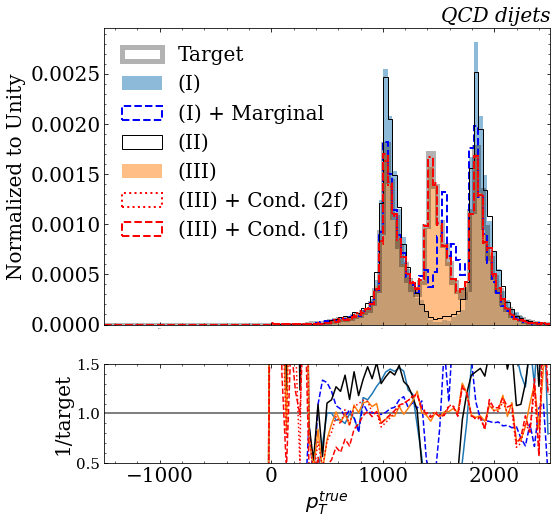

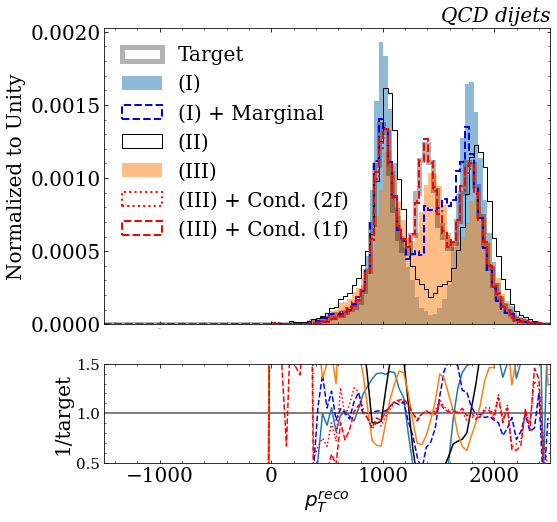

In [48]:
makeplots(Tt_copy4,T0_copy4,T1_copy4,T2_copy4,wT0_copy4,wRT_copy4,wRT2_copy4,xlabel=r"$p_T^{true}$",header="QCD dijets",plotname="Dijets_T",mymin=-1500,mymax=2500,w_withall=w_withall,nbins=100)
makeplots(Rt_copy4,R0_copy4,R1_copy4,R2_copy4,wT0_copy4,wRT_copy4,wRT2_copy4,xlabel=r"$p_T^{reco}$",header="QCD dijets",plotname="Dijets_R",mymin=-1500,mymax=2500,w_withall=w_withall,nbins=100)